In [1]:
import os
import torch
import argparse
import numpy as np

from engine.logger import Logger
from engine.solver import Trainer
from Data.build_dataloader import build_dataloader, build_dataloader_cond
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one
from Utils.io_utils import load_yaml_config, seed_everything, merge_opts_to_config, instantiate_from_config
from Utils.metric_utils import visualization

import sys
import time
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from tqdm import tqdm
from ema_pytorch import EMA
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from Utils.io_utils import instantiate_from_config, get_model_parameters_info


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman') 

import umap                         
import seaborn as sns 

from pypots.utils.metrics import calc_mse,calc_rmse,calc_mae
import random



2025-10-25 21:27:16 [WARNING]: ‼️ `pypots.utils.metrics` is deprecated. Please import from `pypots.nn.functional` instead.



████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 



In [2]:
def visualization2(ori, gen):
    
    Number = ori.shape[0]
    
    max_sample = min([4000, Number])      
    idx = np.random.permutation(Number)[ :max_sample]

    ori1 = np.asarray(ori)[idx]
    gen1 = np.asarray(gen)[idx]

    ori1 = np.mean(ori1, 2) 
    gen1 = np.mean(gen1, 2) 


    concat_data = np.concatenate((ori1, gen1), axis=0)
    
    pca = PCA(2)     
    pca_res = pca.fit_transform(concat_data)

    tsne = TSNE(n_components=2, verbose=1, perplexity=40,random_state=20,n_iter=500) 
    tsne_res = tsne.fit_transform(concat_data) 

    umap_ = umap.UMAP(random_state=42)
    umap_res = umap_.fit_transform(concat_data)
    
    
    fig = plt.figure(figsize=(19,4))
    plt.subplot(1,4,1)
    

    plt.scatter(pca_res[:2000,0],pca_res[:2000,1], s=15, c='#ff7f0e')
    plt.scatter(pca_res[max_sample:max_sample+2000,0],pca_res[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
    plt.xlabel('(a)',fontsize=25)
    
    plt.subplot(1,4,2)
    plt.scatter(tsne_res[:2000,0],tsne_res[:2000,1],  s=15,  c='#ff7f0e')
    plt.scatter(tsne_res[max_sample:max_sample+2000,0],tsne_res[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
    plt.xlabel('(b)',fontsize=25)

    plt.subplot(1,4,3)
    plt.scatter(umap_res[:2000, 0], umap_res[:2000, 1],  cmap='Spectral', s=15,  c='#ff7f0e')
    plt.scatter(umap_res[max_sample:max_sample+2000, 0], umap_res[max_sample:max_sample+2000, 1],  cmap='Spectral', s=15, c='#1f77b4')
    plt.xlabel('(c)',fontsize=25)

    
    plt.subplot(1,4,4)
    sns.distplot(ori[:,:,1], hist=False, color = '#ff7f0e' )
    sns.distplot(gen[:,:,1], hist=False, color = '#1f77b4' )  
    plt.xlabel('(d)',fontsize=25)
    
    

In [3]:
def parse_args():
    parser = argparse.ArgumentParser(description='PyTorch Training Script')
    parser.add_argument('--name', type=str, default=None)

    parser.add_argument('--config_file', type=str, default=None, 
                        help='path of config file')
    parser.add_argument('--output', type=str, default='OUTPUT', 
                        help='directory to save the results')
    parser.add_argument('--tensorboard', action='store_true', 
                        help='use tensorboard for logging')

    # args for random

    parser.add_argument('--cudnn_deterministic', action='store_true', default=False,
                        help='set cudnn.deterministic True')
    parser.add_argument('--seed', type=int, default=10, 
                        help='seed for initializing training.')
    parser.add_argument('--gpu', type=int, default=None,
                        help='GPU id to use. If given, only the specific gpu will be'
                        ' used, and ddp will be disabled')
    
    # args for training
    parser.add_argument('--train', action='store_true', default=False, help='Train or Test.')
    parser.add_argument('--sample', type=int, default=0, 
                        choices=[0, 1], help='Condition or Uncondition.')
    parser.add_argument('--mode', type=str, default='infill',
                        help='Infilling or Forecasting.')
    parser.add_argument('--milestone', type=int, default=10)

    parser.add_argument('--missing_ratio', type=float, default=0., help='Ratio of Missing Values.')
    parser.add_argument('--pred_len', type=int, default=0, help='Length of Predictions.')
    
    
    # args for modify config
    parser.add_argument('opts', help='Modify config options using the command-line',
                        default=None, nargs=argparse.REMAINDER)  

    args = parser.parse_args(args=[])
    args.save_dir = os.path.join(args.output, f'{args.name}')

    return args


# choose dataset

In [4]:
args = parse_args()

# data_name = 'ETTh1'
# data_name = 'Energy'
data_name = 'exchange_rate'
# data_name = 'weather'



if data_name == 'ETTh1':
    args.config_file =  './Config/ETTh1.yaml'

elif data_name == 'Energy':
    args.config_file =  './Config/Energy.yaml'

elif data_name == 'exchange_rate':
    args.config_file =  './Config/exchange_rate.yaml'
    
elif data_name == 'weather':
    args.config_file =  './Config/weather.yaml'
    

args.gpu =  0
args.train = True
print(args)

Namespace(name=None, config_file='./Config/exchange_rate.yaml', output='OUTPUT', tensorboard=False, cudnn_deterministic=False, seed=10, gpu=0, train=True, sample=0, mode='infill', milestone=10, missing_ratio=0.0, pred_len=0, opts=[], save_dir='OUTPUT\\None')


In [5]:
if args.seed is not None:
    seed_everything(args.seed)

if args.gpu is not None:
    torch.cuda.set_device(args.gpu)

config = load_yaml_config(args.config_file)
config = merge_opts_to_config(config, args.opts)


config['dataloader']['batch_size'] = 200
print(config)

beta_schedule = config['model']['params']['beta_schedule'] 
timesteps = config['model']['params']['timesteps'] 
print(beta_schedule, timesteps)

Global seed set to 10
{'model': {'target': 'Models.interpretable_diffusion.gaussian_diffusion.Diffusion_TS', 'params': {'seq_length': 24, 'feature_size': 8, 'n_layer_enc': 4, 'n_layer_dec': 3, 'd_model': 96, 'timesteps': 500, 'sampling_timesteps': 500, 'loss_type': 'l1', 'beta_schedule': 'cosine', 'n_heads': 4, 'mlp_hidden_times': 4, 'attn_pd': 0.0, 'resid_pd': 0.0, 'kernel_size': 1, 'padding_size': 0}}, 'solver': {'base_lr': 1e-05, 'max_epochs': 25000, 'results_folder': './Checkpoints_energy', 'gradient_accumulate_every': 2, 'save_cycle': 2500, 'ema': {'decay': 0.995, 'update_interval': 10}, 'scheduler': {'target': 'engine.lr_sch.ReduceLROnPlateauWithWarmup', 'params': {'factor': 0.5, 'patience': 5000, 'min_lr': 1e-05, 'threshold': 0.1, 'threshold_mode': 'rel', 'warmup_lr': 0.0008, 'warmup': 500, 'verbose': False}}}, 'dataloader': {'train_dataset': {'target': 'Utils.Data_utils.real_datasets.CustomDataset', 'params': {'name': 'energy', 'proportion': 1.0, 'data_root': './Data/datasets/e

In [6]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


if data_name == 'ETTh1':
    load_data = np.load( './Data/datasets/ETTh1.npy')
    
elif data_name == 'Energy':
    load_data = np.load( './Data/datasets/Energy.npy')

elif data_name == 'exchange_rate':
    load_data = np.load( './Data/datasets/exchange_rate.npy')
    
elif data_name == 'weather':
    load_data = np.load( './Data/datasets/weather.npy')
    
    
np.random.shuffle(load_data)

train_data = load_data
test_data = load_data
print(train_data.shape, test_data.shape)

Numble = train_data.shape[0]
Length = train_data.shape[1]
Feature = train_data.shape[2]
Batchsize = 200


class MyDataset(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        x = torch.tensor(self.X_data[idx], dtype=torch.float32)  
        return x   
                    
dataset = MyDataset(train_data)    
dataloader = DataLoader(dataset, batch_size=Batchsize, shuffle=True)

def cycle(dl):         
    while True:
        for data in dl:
            yield data
            
dl = cycle( dataloader )
print( next(dl).shape )

(2522, 24, 8) (2522, 24, 8)
torch.Size([200, 24, 8])


In [7]:
def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def exists(x):
    return x is not None

from Models.interpretable_diffusion.model_utils import default, identity, extract
from Models.interpretable_diffusion.gaussian_diffusion import linear_beta_schedule, cosine_beta_schedule, Diffusion_TS
import torch.nn.functional as F


shape = (Numble, Length, Feature)
print(shape)


(2522, 24, 8)


In [8]:
rf_model = instantiate_from_config(config['model']).cuda()
print(rf_model.use_ff, rf_model.num_timesteps, rf_model.loss_type)
print(rf_model.sampling_timesteps, rf_model.fast_sampling)

True 500 l1
500 False


In [1]:
device = rf_model.betas.device
gradient_accumulate_every = config['solver']['gradient_accumulate_every'] 


In [12]:
start_lr = config['solver'].get('base_lr', 1.0e-4)
ema_decay = config['solver']['ema']['decay']
ema_update_every = config['solver']['ema']['update_interval']
ema = EMA(rf_model, beta=ema_decay, update_every=ema_update_every).to(device)

opt = Adam(filter(lambda p: p.requires_grad, rf_model.parameters()), lr=start_lr, betas=[0.9, 0.96])
# print(opt)

sc_cfg = config['solver']['scheduler']
sc_cfg['params']['optimizer'] = opt    
sch = instantiate_from_config(sc_cfg)   


In [13]:
ds = 1 / torch.tensor([2 ** i for i in range(1, 8)]).to(device)
ds_p = torch.ones((ds.shape[0],)).to(device) / ds.shape[0]

d = ds[ds_p.multinomial(10, replacement=True).to(device)]
# print(d, d.shape)

t = torch.rand(size=(10, 1), device=device)
# print(t,t.shape)


def reshape_coefs(t):
    return t.reshape((t.shape[0], 1,  1))


# load trained model

In [14]:
rf_model = instantiate_from_config(config['model']).cuda()

rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/exchange_rate_rf.pth"  ))
ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/exchange_rate_ema_rf.pth"  ))

# rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/weather_rf.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/weather_ema_rf.pth"  ))

# rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/ETTh1_rf.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/ETTh1_ema_rf.pth"  ))

# rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/Energy_rf.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/Energy_ema_rf.pth"  ))



<All keys matched successfully>

# conduct pre-imputation and refinement by FireFlow inversion and sampling

In [15]:
from torch.autograd import Variable

def get_mask_mcar(sample, mr): 
    mask = torch.ones(sample.shape).view(1,-1) 
    index = torch.tensor(range(mask.shape[1]))  
    perm = torch.randperm(len(index)) 
    index = perm[ 0: round( mr*len(index) ) ]
    mask[0][index]=0
    mask = mask.view(sample.shape)
    return mask


def get_mask_mnr(sample, k):  
    mask = torch.ones(sample.shape)
    length_index = torch.tensor(range(mask.shape[0]))
    list_of_segments_index = torch.split(length_index, k)
    for channel in range(mask.shape[1]):
        s_nan = random.choice(list_of_segments_index)
        mask[:, channel][s_nan[0]:s_nan[-1] + 1] = 0

    return mask

print(train_data.shape )

(2522, 24, 8)


In [16]:
target = torch.tensor( load_data ).float().cuda()
shape = target.shape
print(shape)
b, c, n, = target.shape

padding_masks = torch.ones(b, c, dtype=bool, device=device)

torch.Size([2522, 24, 8])


# choose missing mechanism, rate and pre-imputation method

In [17]:
mr = 0.3
# mechanism = 'mcar'  
mechanism = 'mnr' 
missing_length = int( mr * Length )
print(mr, missing_length)

pre_imputation = 'csdi'
# pre_imputation = 'SAITS'
# pre_imputation = 'Pyraformer'
# pre_imputation = 'ImputeFormer'

0.3 7


# makes train dataset and test dataset

In [18]:
Mask = torch.empty([0, c, n])    
print( Mask.shape)

for i in range(target.shape[0]):
    if mechanism == 'mcar':
        one_mask = get_mask_mcar( target[0], mr)  
    else:
        one_mask = get_mask_mnr( target[0], missing_length) 

    one_mask = one_mask.unsqueeze(0)   
    Mask = torch.row_stack([Mask, one_mask])

Mask = Mask.float().cuda()
train_data = target * Mask
train_data[train_data == 0] = np.nan
train_set = {"X": train_data}

print( Mask.shape )

torch.Size([0, 24, 8])
torch.Size([2522, 24, 8])


In [19]:
Mask_test = torch.empty([0, c, n])    
for i in range(target.shape[0]):
    if mechanism == 'mcar':
        one_mask = get_mask_mcar( target[0], mr)  
    else:
        one_mask = get_mask_mnr( target[0], missing_length) 

    one_mask = one_mask.unsqueeze(0)   
    Mask_test = torch.row_stack([Mask_test, one_mask])
    
Mask_test = Mask_test.float().cuda()
print( Mask_test.shape )


test_data = target * Mask_test
test_data[test_data == 0] = np.nan
test_set =  {"X": test_data}
print(mr, mechanism, test_data.shape)


torch.Size([2522, 24, 8])
0.3 mnr torch.Size([2522, 24, 8])


In [20]:
from pypots.imputation import Pyraformer
from pypots.imputation import SAITS  
from pypots.imputation import ImputeFormer
from pypots.imputation import CSDI
from pypots.optim import Adam

# conduct pre-imputation

In [92]:
if pre_imputation == 'Pyraformer':
    pyraformer = Pyraformer( 
        n_steps = train_data.shape[1], n_features = train_data.shape[2],
        n_layers= 4, n_heads = 4,
        d_model = 256, d_ffn = 512,
        window_size = [1, 1, 1],
        inner_size = 3,
        dropout = 0.1,
        batch_size=200, epochs=1000,  )

    pyraformer.fit( train_set = train_set  )

    
elif pre_imputation == 'SAITS':
    saits = SAITS(n_steps=train_data.shape[1], n_features=train_data.shape[2],
                  n_layers=2, d_model=256, n_heads=4, d_k=64, d_v=64, d_ffn=128, dropout=0.1, 
    #               n_layers=2, d_model=256, n_heads=4, d_k=128, d_v=128, d_ffn=128, dropout=0.1, 
                  num_workers=0, optimizer=Adam(lr=1e-3), 
                  batch_size=200, epochs=800, )   

    saits.fit( train_set = train_set) 
    
    
elif pre_imputation == 'ImputeFormer':
    imputeFormer = ImputeFormer( 
    n_steps = train_data.shape[1], n_features = train_data.shape[2],
    n_layers=4,
    d_input_embed= 24, d_learnable_embed=128,     
    d_proj= 36,  d_ffn=256, 
    n_temporal_heads=4, 
    ORT_weight=1, MIT_weight=1,
    batch_size=200, epochs=400,  )
    
    imputeFormer.fit( train_set = train_set  )
    

elif pre_imputation == 'csdi':
    csdi = CSDI(
        n_steps= train_data.shape[1], n_features= train_data.shape[2],
        n_layers=6, n_heads=2, n_channels=128,
        d_time_embedding=64, d_feature_embedding=32, d_diffusion_embedding=128,
        target_strategy="random",
        n_diffusion_steps=50,
        batch_size=200,             
        epochs=200,
        optimizer=Adam(lr=1e-3),
        num_workers=0, )
    
    csdi.fit( train_set = train_set )

2025-10-25 21:13:21 [INFO]: No given device, using default device: cuda
2025-10-25 21:13:21 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-10-25 21:13:21 [INFO]: CSDI initialized with the given hyperparameters, the number of trainable parameters: 1,693,825
2025-10-25 21:13:23 [INFO]: Epoch 001 - training loss (default): 0.5248
2025-10-25 21:13:25 [INFO]: Epoch 002 - training loss (default): 0.1854
2025-10-25 21:13:27 [INFO]: Epoch 003 - training loss (default): 0.1108
2025-10-25 21:13:30 [INFO]: Epoch 004 - training loss (default): 0.0774
2025-10-25 21:13:32 [INFO]: Epoch 005 - training loss (default): 0.0612
2025-10-25 21:13:34 [INFO]: Epoch 006 - training loss (default): 0.0533
2025-10-25 21:13:37 [INFO]: Epoch 007 - training loss (default): 0.0489
2025-10-25 21:13:39 [INFO]: Epoch 008 - training loss (default): 0.0479
2025-10-25 21:13:41 [INFO]: Epoch 009 - training loss (default): 0.0527
2025-10-25 21:13:43 [INFO]: Epoch 010 - training

2025-10-25 21:17:26 [INFO]: Epoch 111 - training loss (default): 0.0191
2025-10-25 21:17:29 [INFO]: Epoch 112 - training loss (default): 0.0191
2025-10-25 21:17:31 [INFO]: Epoch 113 - training loss (default): 0.0183
2025-10-25 21:17:33 [INFO]: Epoch 114 - training loss (default): 0.0168
2025-10-25 21:17:35 [INFO]: Epoch 115 - training loss (default): 0.0156
2025-10-25 21:17:38 [INFO]: Epoch 116 - training loss (default): 0.0187
2025-10-25 21:17:40 [INFO]: Epoch 117 - training loss (default): 0.0150
2025-10-25 21:17:42 [INFO]: Epoch 118 - training loss (default): 0.0175
2025-10-25 21:17:44 [INFO]: Epoch 119 - training loss (default): 0.0187
2025-10-25 21:17:46 [INFO]: Epoch 120 - training loss (default): 0.0189
2025-10-25 21:17:48 [INFO]: Epoch 121 - training loss (default): 0.0197
2025-10-25 21:17:51 [INFO]: Epoch 122 - training loss (default): 0.0169
2025-10-25 21:17:53 [INFO]: Epoch 123 - training loss (default): 0.0162
2025-10-25 21:17:55 [INFO]: Epoch 124 - training loss (default):

In [93]:
if pre_imputation == 'Pyraformer':
    result_pre = pyraformer.predict(test_set)
    
elif pre_imputation == 'SAITS':
    result_pre = saits.predict(test_set)
    
elif pre_imputation == 'ImputeFormer':
    result_pre = imputeFormer.predict(test_set)
    
elif pre_imputation == 'csdi':
    result_pre = csdi.predict(test_set, n_sampling_times=2)  
    
if pre_imputation == 'csdi':
    result_pre = result_pre["imputation"]
    result_pre = result_pre.mean(axis=1)
else:   
    result_pre = result_pre["imputation"]

# pre-imputation RMSE

In [95]:
rmse = calc_rmse( result_pre, target.cpu().numpy(), 1-Mask_test.cpu().numpy())
mae = calc_mae( result_pre, target.cpu().numpy(), 1-Mask_test.cpu().numpy())  
print(np.around(rmse,5), np.around(mae,5) )

0.0198 0.01284


# refine pre-imputation by FireFlow inversion and sampling
# choose hyper-parameters N K D

In [96]:
n_steps = 10   # N
eps = 1e-8

b, c, n, =  result_pre.shape
print(result_pre.shape)
# d = torch.tensor(1 / n_steps).to(device)

padding_masks = torch.ones(b, c, dtype=bool, device=device)

d = ds[ds_p.multinomial(b, replacement=True).to(device)]
d[:b] = 0 

(2522, 24, 8)


In [97]:
import time

loss_list = []
loss_missing_list = []

inversion_iter = 2   # K
refine_iter = 2     # D

pbar = tqdm( total= inversion_iter * refine_iter + inversion_iter )   

start_time = time.time()

for j in range(0, inversion_iter ):
    
    if j == 0:       
        x_t = torch.tensor(result_pre).cuda()*(1- Mask_test) + target*Mask_test
    else:          
        x_t = refined_res*(1- Mask_test) + target*Mask_test
        
    t = torch.linspace( eps, 1 - eps, n_steps+1 ).to(device)

    
    'FireFlow inversion'     
    v_hat = None

    for i in range( len(t)-1, 0, -1):  
        t_batch = t[i].unsqueeze(0).repeat((b,))
        if v_hat == None:
            with torch.no_grad():
                v_pred = ema.ema_model.output(x_t, t_batch, d=d, padding_masks=padding_masks) 
        else:
            v_pred = v_hat         

        x_mid =  x_t - ( ( t[i] - t[i-1] )/2 ) * v_pred
        t_mid = t[i] - ( t[i]- t[i-1] )/2
        t_mid_batch = t_mid.unsqueeze(0).repeat((b,))

        with torch.no_grad():
            v_mid = ema.ema_model.output(x_mid, t_mid_batch, d=d, padding_masks=padding_masks) 

        v_hat = v_mid   
        x_t = x_t - ( t[i]- t[i-1] ) * v_mid     
        
        
    
    inverted_code = Variable( x_t, requires_grad = True)
    optimizer = torch.optim.Adam(  [inverted_code], lr=0.001)  

    pbar.update(1)
    
    
    'FireFlow sampling' 
    for i in range(0, refine_iter):
        
        x_t = inverted_code

        v_hat = None

        for i in range(0, len(t)-1):
            t_batch = t[i].unsqueeze(0).repeat((b,))

            if v_hat == None:
                with torch.no_grad():
                    v_pred = ema.ema_model.output(x_t, t_batch, d=d, padding_masks=padding_masks) 
            else:
                v_pred = v_hat        

            x_mid =  x_t + ( ( t[i+1] - t[i] )/2 ) * v_pred
            t_mid = t[i] + ( t[i+1] - t[i] )/2
            t_mid_batch = t_mid.unsqueeze(0).repeat((b,))

            with torch.no_grad():
                v_mid = ema.ema_model.output(x_mid, t_mid_batch, d=d, padding_masks=padding_masks) 

            v_hat = v_mid    
            x_t = x_t + ( t[i+1] - t[i] ) * v_mid


        refined_res = x_t

        loss = F.mse_loss( x_t*Mask_test, target*Mask_test, reduction="none") 
        loss = loss.sum()/Mask.sum()
#         loss = loss.sum()/Mask_test.sum()    
        loss_list.append(loss.item() )


        loss_missing = F.mse_loss( x_t*(1-Mask_test), target*(1-Mask_test), reduction="none")  
        loss_missing = loss_missing.sum()/(1-Mask_test).sum()
        loss_missing_list.append(loss_missing.item() )

        loss.float().backward() 
        optimizer.step()
        optimizer.zero_grad()

        pbar.update(1)
        
pbar.close()

end_time = time.time()
execution_time = end_time - start_time
print(f"time: {execution_time} s")

print( refined_res.shape)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.06it/s]

time: 5.643138885498047 s
torch.Size([2522, 24, 8])


[0.01752 0.0175  0.01657 0.01654]


Text(0.5, 1.0, 'evolution of refined RMSE')

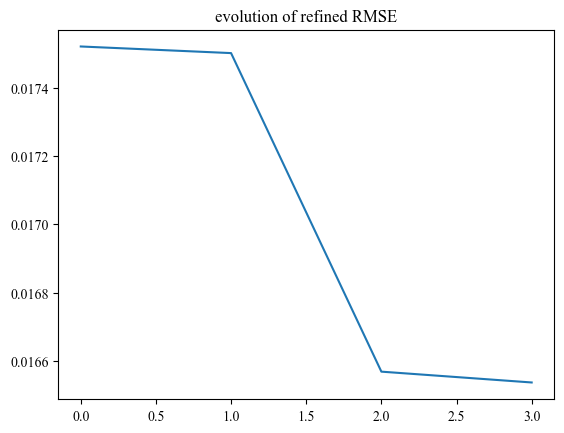

In [98]:
rmse1 = list( map(lambda x: x ** (1/2), loss_list) )
rmse2 = list( map(lambda x: x ** (1/2), loss_missing_list) )
print( np.around( rmse2, 5 )  )


plt.figure()
plt.plot(rmse2)
plt.title('evolution of refined RMSE')

# refined RMSE

In [99]:
rmse = calc_rmse( refined_res, target,1-Mask_test).cpu()
mae = calc_mae( refined_res, target, 1-Mask_test).cpu() 
print( 'RMSE', rmse )
print( 'MAE', mae )

RMSE tensor(0.0165, grad_fn=<ToCopyBackward0>)
MAE tensor(0.0107, grad_fn=<ToCopyBackward0>)


# use vanilla flow inversion and sampling to refine pre-imputation

In [100]:
n_steps = 100  
eps = 1e-8
b, c, n, =  result_pre.shape
print(result_pre.shape)
# d = torch.tensor(1 / n_steps).to(device)

padding_masks = torch.ones(b, c, dtype=bool, device=device)

d = ds[ds_p.multinomial(b, replacement=True).to(device)]
d[:b] = 0 


loss_list = []
loss_missing_list = []

inversion_iter = 2
refine_iter = 2

pbar = tqdm( total= inversion_iter * refine_iter + inversion_iter )   


start_time = time.time()


for j in range(0, inversion_iter  ):
    
    if j==0:      
        x_t = torch.tensor(result_pre).cuda()*(1- Mask_test) + target*Mask_test
    else:         
        x_t = refined_res*(1- Mask_test) + target*Mask_test
        
    
    t = torch.linspace( 1-eps, eps, n_steps+1 ).to(device)

    'vanilla flow inversion'
    for i in range(1, len(t)):
        t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))
        with torch.no_grad():
            v_pred = ema.ema_model.output(x_t, t_batch, d=d, padding_masks=padding_masks) 
        x_t = x_t - (t[i-1] - t[i]) * v_pred
        
    inverted_code = Variable( x_t, requires_grad=True)
    optimizer = torch.optim.Adam(  [inverted_code], lr=0.001)  

    pbar.update(1)
    
    
    'vanilla flow sampling'
    t = torch.linspace( eps, 1-eps , n_steps+1 ).to(device)
        
    for i in range(0, refine_iter):
        
        x_t = inverted_code

        for i in range(1, len(t)):
            t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))

            with torch.no_grad():
                v_pred = ema.ema_model.output(x_t, t_batch, d=d, padding_masks=padding_masks) 

            x_t = x_t + (t[i] - t[i - 1]) * v_pred

        refined_res = x_t

        loss = F.mse_loss( x_t*Mask_test , target*Mask_test , reduction="none")
        
        loss = loss.sum()/Mask.sum()
#         loss = loss.sum()/Mask_test.sum()
        
        loss_list.append(loss.item() )


        loss_missing = F.mse_loss( x_t*(1-Mask_test), target*(1-Mask_test), reduction="none")
        loss_missing = loss_missing.sum()/(1-Mask_test).sum()
        loss_missing_list.append(loss_missing.item() )


        loss.float().backward() 
        optimizer.step()
        optimizer.zero_grad()

        pbar.update(1)

pbar.close()


end_time = time.time()
execution_time = end_time - start_time
print(f"time: {execution_time} s")

print( refined_res.shape)

(2522, 24, 8)


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:48<00:00,  8.11s/it]

time: 48.650617837905884 s
torch.Size([2522, 24, 8])


[0.01783 0.01766 0.01751 0.0171 ]


Text(0.5, 1.0, 'evolution of refined RMSE')

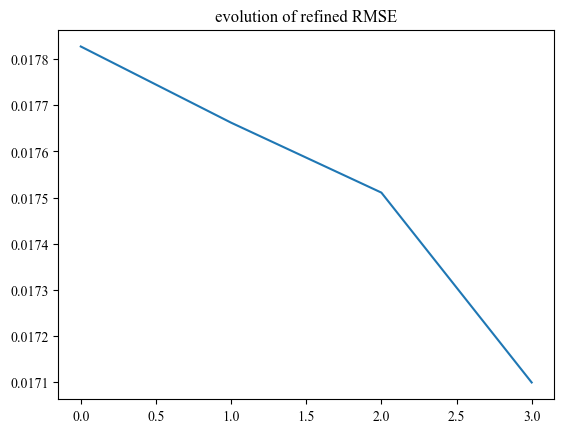

In [101]:
rmse1 = list( map(lambda x: x ** (1/2), loss_list) )
rmse2 = list( map(lambda x: x ** (1/2), loss_missing_list) )
print( np.around( rmse2, 5 )  )

plt.figure()
plt.plot(rmse2)
plt.title('evolution of refined RMSE')

In [102]:
rmse = calc_rmse( refined_res, target,1-Mask_test).cpu()
mae = calc_mae( refined_res, target, 1-Mask_test).cpu() 
print( 'RMSE', rmse )
print( 'MAE', mae )

RMSE tensor(0.0171, grad_fn=<ToCopyBackward0>)
MAE tensor(0.0113, grad_fn=<ToCopyBackward0>)
